In [1]:
# Import relevant packages

import pandas as pd
import re
import string
from collections import defaultdict

#Importing NLTK 
import nltk
from nltk import word_tokenize

nltk.download(["names","stopwords","averaged_perceptron_tagger","punkt"])

#Importing sentiment lexicons
from nltk.sentiment import SentimentIntensityAnalyzer #VADER
from afinn import Afinn #AFINN

#Importing packages for visualizations
import matplotlib.pyplot as plt 
import seaborn as sns

#Importing scipy and statsmodels' lowess regression function
import scipy 
from statsmodels.nonparametric.smoothers_lowess import lowess


[nltk_data] Downloading package names to
[nltk_data]     C:\Users\Frederikke\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Frederikke\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Frederikke\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Frederikke\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# ASDS2 Exercises

## April 26: Sentiment analysis

In this exercise, you will be replicating part of the sentiment analysis from the paper 'Tones from a Narrowing Race: Polling and Online Political Communication during the 2014 Scottish Referendum Campaign' by Evelyne Brie and Yannick Dufresne (2018). 

More specifically, you will be checking their results by implementing sentiment analysis with two alternative sentiment lexicons: the AFINN and VADER (Valence Aware Dictionary and sEntiment Reasoner) lexicons. 

### 1: Importing aggregated data

The file 'PollData-ForRegression.csv' contains the aggregated data and sentiment results as used in the paper. The variable 'scoreDayAvg' shows their computed sentiment scores. Import this data for comparison. 

1. Import 'PollData-ForRegression.csv'
2. Convert 'date' from a string type to datetime type variable

In [2]:
#Loading the dataset
agg = pd.read_csv('PollData-ForRegression.csv', delimiter = ';')
print(agg.shape)
agg.head()


(190, 16)


,X,dateNumber,date,shareYes,shareNo,shareDk,diffPollAvance,diffPollGain,yesScotland,scoreDayAvg,scoreDayAvgGain,period,period1,period2,period3,pollDay
0,1,1,14-06-15,36,43,21,-7,NaN,1,1.500000,NaN,Pre-debates,1,0,0,1
1,2,2,14-06-16,36,53,11,-17,-10.0,1,1.120000,-0.380000,Pre-debates,1,0,0,1
2,3,3,14-06-17,36,53,11,-17,-10.0,1,0.958333,-0.161667,Pre-debates,1,0,0,0
3,4,4,14-06-18,36,53,11,-17,-10.0,1,0.818182,-0.140152,Pre-debates,1,0,0,0
4,5,5,14-06-19,36,53,11,-17,-10.0,1,0.500000,-0.318182,Pre-debates,1,0,0,0


In [3]:
#Converting 'date' variables from string to datetime objects

agg['date'] = pd.to_datetime(agg['date'], format = '%y-%m-%d', errors = 'ignore')


### 2: Preprocessing raw tweet data

The dataset 'Tones_Tweets.csv' contains the raw tweets that we will be working with.

1. Load in the dataset 'Tones_Tweets.csv', containing tweets from Yes Scotland and Better Together
2. Convert 'date' from a string type to datetime type variable
3. Isolate a subset of the data corresponding to the period used in the article, i.e. 15/06/2014 - 17/09/2014

In [4]:
#Loading the dataset
tweets = pd.read_csv('Tones_Tweets.csv',encoding='latin-1')
tweets.shape

(5933, 3)

In [5]:
#Converting 'date' variables from string to datetime objects
tweets['date'] = pd.to_datetime(tweets['date'], format = '%Y-%m-%d', errors = 'ignore')


In [6]:
#Getting subset of dataset spanning 15.06.2014 - 17.09.2014
tweets = tweets[(tweets.date >= '2014-06-15') &
                (tweets.date <= '2014-09-17')]

#Resetting index 
tweets.reset_index(inplace = True, drop = True)


In [7]:
print(tweets.shape)
tweets.head()

(4108, 3)


,text,date,campaign
0,With a Yes vote we can protect our valued NHS ...,2014-09-17,Yes Scotland
1,The independence debate has seen democracy flo...,2014-09-17,Yes Scotland
2,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland
3,Got #indyref questions? Get you answers here: ...,2014-09-17,Yes Scotland
4,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland


### 2: Preprocessing continued

Next, use the steps from the lecture last week to preprocess the data as you see fit. Although mentioned below, not all preprocessing will make a difference in sentiment analysis, as e.g. punctuation will not have a positive or negative valence, and you can therefore get by with fewer preprocessing steps than suggested. 

Suggestions for preprocessing: 

4. Lowercase all words
5. Remove 'RT' and 'via'
6. Remove all mentions (@some_one)
7. Remove common words used in the campaigns that may add noise to the sentiment analysis, such as 'better', 'together' 'darling', 'yes', 'no' and combinations like 'bettertogether'
8. Remove numbers, punctuation, separators, and urls
9. Lemmatize
10. Remove stopwords

In [8]:
#Creating a code that includes all preprocessing steps 
#Note that it is important to do these steps in the right order,
     #e.g. if punctuation is removed before mentions, regex will not be able to distinguish metions as @ will have been removed.

def preprocess(text):
    
    #Lowercasing words
    text = text.lower()
    
    #Removing 'RT' and 'via'
    text = re.sub('(^rt|^via)((?:\\b\\W*@\\w+)+): ', '', text)
    
    #Removing mentions 
    text = re.sub(r'@\w+ ', '', text)             
    
    #Removing frequent words and combinations
    text = re.sub("(?i)better","", text)              #(?i) starts case-insensitive mode
    text = re.sub("(?i)together","", text)
    text = re.sub("(?i)bettertogether","", text)
    text = re.sub("(?i)darling","", text)
    text = re.sub("(?i)\\byes\\b","", text)
    text = re.sub("(?i)\\bno\\b","", text)
    
    #Removing URLs
    text = re.sub(r'http\S+', '', text)
    
    #Removing numbers
    text = re.sub(r'[0-9.]','', text)
    
    #Removing separators and superfluous whitespace
    text = text.strip()
    text = re.sub(' +',' ',text)
    
    #Removing punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    #Lemmatizing
    tag_map = defaultdict(lambda : nltk.corpus.wordnet.NOUN)      #POS map
    tag_map['J'] = nltk.corpus.wordnet.ADJ
    tag_map['V'] = nltk.corpus.wordnet.VERB
    tag_map['R'] = nltk.corpus.wordnet.ADV    
    
    lemmatizer = nltk.WordNetLemmatizer()             #Creating lemmatizer.
    
    tokens = nltk.word_tokenize(text)                 #Tokenizing, as lemmatizer only takes tokenized sentences
    text_lemmatized = []                              #Empty list to save lemmatized sentence

    for word, tag in nltk.pos_tag(tokens):
        lemma = lemmatizer.lemmatize(word, tag_map[tag[0]])
        text_lemmatized.append(lemma)
    
    text = " ".join(text_lemmatized)
    
    #Removing stopwords
    stop_words_list = nltk.corpus.stopwords.words("english")
    text = " ".join([i for i in nltk.word_tokenize(text) if i not in stop_words_list])
    
    return text



In [9]:
tweets['text_preprocessed'] = tweets['text'].apply(lambda x: preprocess(x))


In [10]:
tweets.head()

,text,date,campaign,text_preprocessed
0,With a Yes vote we can protect our valued NHS ...,2014-09-17,Yes Scotland,vote protect value nhs indyref voteyes
1,The independence debate has seen democracy flo...,2014-09-17,Yes Scotland,independence debate see democracy flourish lik...
2,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland,one way guarantee scotland get power need vote...
3,Got #indyref questions? Get you answers here: ...,2014-09-17,Yes Scotland,get indyref question get answer
4,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland,one way guarantee scotland get power need vote...


### 3: Sentiment analysis 

Calculate a sentiment score for each tweet using the VADER and AFINN lexicons for sentiment analysis. 

The VADER lexicon is the sentiment analyzer integrated in NLTK and can be imported using `from nltk.sentiment import SentimentIntensityAnalyzer`. VADER summarizes the sentiment score for each sentence in a normalized variable called 'compound', scoring sentences between -1 (most negative) to 1 (most positive). Read about the VADER sentiment scoring here: https://github.com/cjhutto/vaderSentiment#about-the-scoring.

The AFINN lexicon can be imported using `from afinn import Afinn`. AFINN ranks words on a scale from -5 to 5 and computes the resulting sum for full sentences. Sentences with negative score are categorized as negative, sentences with a score of 0 are neutral, and sentences with a positive score are positive. 


##### VADER (Valence Aware Dictionary and sEntiment Reasoner) 

In [11]:
#Importing the sentiment analyzer
vader = SentimentIntensityAnalyzer()

#Computing score for a random test sentence 
test_preprocessed = tweets['text_preprocessed'][976]
test_original = tweets['text'][976]

print(test_original, '\n\n', test_preprocessed, '\n\n', vader.polarity_scores(test_preprocessed))

#Notice that 'us' has become 'u' in this preprocessed sentence. This is an example of lemmatization not working quite as it should. 


Yes gives us the opportunity to massively increase childcare  #indyref #voteYes #Scotland http://t.co/a6cLBeQNaw 

 give u opportunity massively increase childcare indyref voteyes scotland 

 {'neg': 0.0, 'neu': 0.541, 'pos': 0.459, 'compound': 0.6249}


In [12]:
#Running sentiment analysis with vader lexicon on all tweets

tweets['vader_neg'] = 0
tweets['vader_neu'] = 0
tweets['vader_pos'] = 0
tweets['vader_compound'] = 0

for i in range(tweets.shape[0]): 
    
    score = vader.polarity_scores(tweets['text_preprocessed'][i])
        
    tweets.loc[i,'vader_neg'] = score['neg']
    tweets.loc[i,'vader_neu'] = score['neu']
    tweets.loc[i,'vader_pos'] = score['pos']
    tweets.loc[i,'vader_compound'] = score['compound']


##### AFINN

In [13]:
#Importing the sentiment analyzer
afinn = Afinn()

#Computing score for the same test sentence 
print(test_original, '\n\n', test_preprocessed, '\n\n', afinn.score(test_preprocessed))


Yes gives us the opportunity to massively increase childcare  #indyref #voteYes #Scotland http://t.co/a6cLBeQNaw 

 give u opportunity massively increase childcare indyref voteyes scotland 

 3.0


In [14]:
#Running sentiment analysis with afinn lexicon on all tweets

tweets['afinn_sentimentscore'] = 0

for i in range(tweets.shape[0]): 
    
    score = afinn.score(tweets['text_preprocessed'][i])

    tweets.loc[i,'afinn_sentimentscore'] = score
    

In [15]:
tweets.head()

,text,date,campaign,text_preprocessed,vader_neg,vader_neu,vader_pos,vader_compound,afinn_sentimentscore
0,With a Yes vote we can protect our valued NHS ...,2014-09-17,Yes Scotland,vote protect value nhs indyref voteyes,0.0,0.444,0.556,0.6124,1.0
1,The independence debate has seen democracy flo...,2014-09-17,Yes Scotland,independence debate see democracy flourish lik...,0.0,0.783,0.217,0.3612,2.0
2,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland,one way guarantee scotland get power need vote...,0.0,0.800,0.200,0.2500,1.0
3,Got #indyref questions? Get you answers here: ...,2014-09-17,Yes Scotland,get indyref question get answer,0.0,1.000,0.000,0.0000,0.0
4,There's only ONE way to guarantee Scotland get...,2014-09-17,Yes Scotland,one way guarantee scotland get power need vote...,0.0,0.800,0.200,0.2500,1.0


##### MEAN SENTIMENT SCORE PER CAMPAIGN

Use Panda's `groupby` function to calculate the mean sentiment score per campaign for each lexicon (VADER and AFINN) and compare with the mean sentiment score in PollData-ForRegression.csv. Which campaign is on average more positive? Is this consistent with the results in the paper?

In [16]:
#Mean sentiment scores per campaign, computed with VADER and AFINN

tweets.groupby("campaign").mean()


,vader_neg,vader_neu,vader_pos,vader_compound,afinn_sentimentscore
campaign,,,,,
Better Together,0.057817,0.746814,0.195376,0.234583,1.133906
Yes Scotland,0.042936,0.739241,0.217485,0.273444,1.282705


In [17]:
#Mean sentiment sores per campaign, computed with Bing lexicon (results from the paper)

agg.groupby('yesScotland').mean()['scoreDayAvg']

yesScotland
0    0.29997
1    0.60041
Name: scoreDayAvg, dtype: float64

##### CORRELATIONS

Do the authors' sentiment scores correlate with the sentiment scores calculated by us via the AFINN and VADER lexicons?

Correlate the authors' calculated sentiment scores with the sentiment scores computed with the AFINN and VADER lexicons per campaign. Visualize these correlations as scatterplots. 

Hint: The authors' sentiment scores are aggregated into average sentiment scores for each campaign per day. To correlate with their score, you will need to aggregate your data in the same way. Panda's `groupby` function can help you with this. Then, correlations can be found using the `scipy.stats.pearsonr` function. 

In [18]:
#Defining arrays to correlate. 
#Dividing the dataframes by campaign and lexicon and taking the average sentiment score per day.

Y_author = agg.loc[agg.yesScotland == 1]['scoreDayAvg'].values
N_author = agg.loc[agg.yesScotland == 0]['scoreDayAvg'].values

Y_vader = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean()['vader_compound'].values
N_vader = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean()['vader_compound'].values

Y_afinn = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean()['afinn_sentimentscore'].values
N_afinn = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean()['afinn_sentimentscore'].values


In [19]:
#Computing correlations for each campaign and each of our lexicons versus the authors' lexicon
#Using Pearson's r from scipy package

r, p = scipy.stats.pearsonr(Y_author, Y_vader)
print("Authors' vs. VADER, Yes Scotland: \tcorr {}, \tp-value {}".format(r,p))

r, p = scipy.stats.pearsonr(N_author, N_vader)
print("Authors' vs. VADER, Better Together: \tcorr {}, \tp-value {}".format(r,p))

r, p = scipy.stats.pearsonr(Y_author, Y_afinn)
print("Authors' vs. AFINN, Yes Scotland: \tcorr {}, \tp-value {}".format(r,p))

r, p = scipy.stats.pearsonr(N_author, N_afinn)
print("Authors' vs. AFINN, Better Together: \tcorr {}, \tp-value {}".format(r,p))


Authors' vs. VADER, Yes Scotland: 	corr 0.8165721546957361, 	p-value 6.436708580988861e-24
Authors' vs. VADER, Better Together: 	corr 0.6840485403446465, 	p-value 2.158866879960519e-14
Authors' vs. AFINN, Yes Scotland: 	corr 0.77212676189977, 	p-value 5.1706502375027665e-20
Authors' vs. AFINN, Better Together: 	corr 0.8044873555337682, 	p-value 9.303322989212091e-23


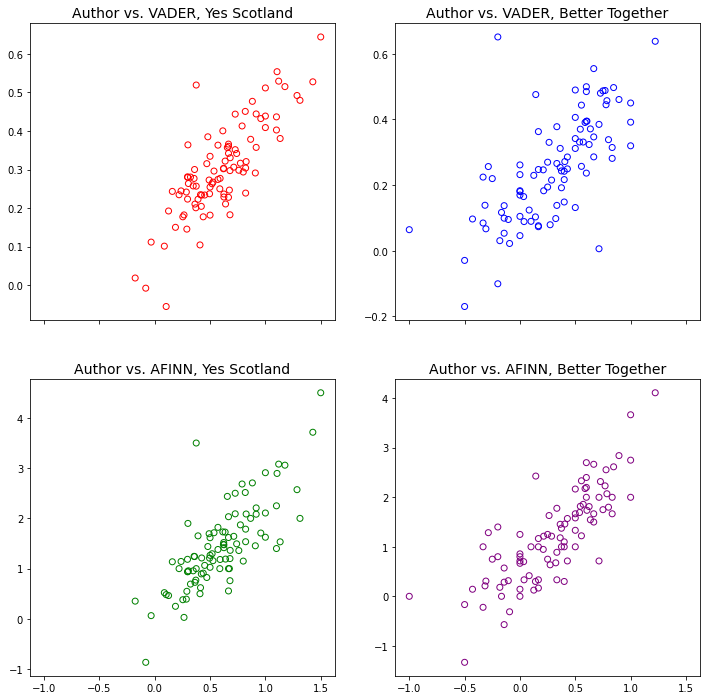

In [20]:
#Visualizing the correlations

fig, axs = plt.subplots(2, 2, sharex = True, figsize = (12,12))

axs[0, 0].scatter(Y_author, Y_vader, facecolors='none', edgecolors='r')
axs[0, 0].set_title('Author vs. VADER, Yes Scotland', fontsize = 14)

axs[0, 1].scatter(N_author, N_vader, facecolors='none', edgecolors='b')
axs[0, 1].set_title('Author vs. VADER, Better Together', fontsize = 14)

axs[1, 0].scatter(Y_author, Y_afinn, facecolors='none', edgecolors='g')
axs[1, 0].set_title('Author vs. AFINN, Yes Scotland', fontsize = 14)

axs[1, 1].scatter(N_author, N_afinn, facecolors='none', edgecolors='purple')
axs[1, 1].set_title('Author vs. AFINN, Better Together', fontsize = 14);


##### BARCHART VISUALIZATIONS

Visualize the distribution of sentiment scores per campaign by creating a barchart for each lexicon. Check whether the campaign sentiments are skewed toward positive or negative. 

Hint: Through matplotlib, `hist()` will give you a barchart. With seaborn, you can use `histplot()` or `countplot()`. 


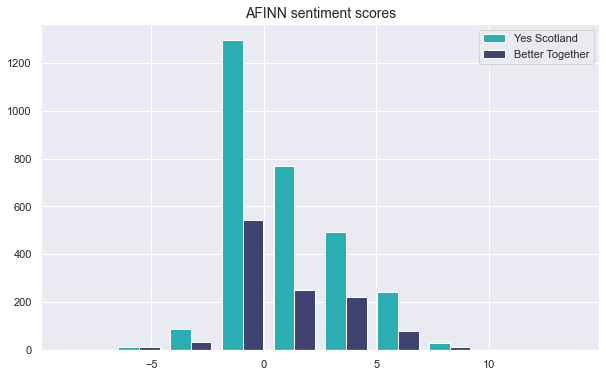

In [21]:
#Visualizing the sentiment scores as a barchart 

plt.figure(figsize = (10,6))
sns.set_theme(style="darkgrid")

colors = ['#2BAEB3', '#404272']
labels = ['Yes Scotland','Better Together']

#Splitting AFINN sentiment scores for the Yes and No campaigns into two arrays in one list
x_multi = [tweets.loc[tweets.campaign == 'Yes Scotland']['afinn_sentimentscore'].values,tweets.loc[tweets.campaign == 'Better Together']['afinn_sentimentscore'].values]

#Plotting the sentiment scores as a barchart
plt.hist(x_multi, histtype='bar', color = colors, label = labels)
plt.title('AFINN sentiment scores', fontsize = 14)
plt.legend()

plt.show()

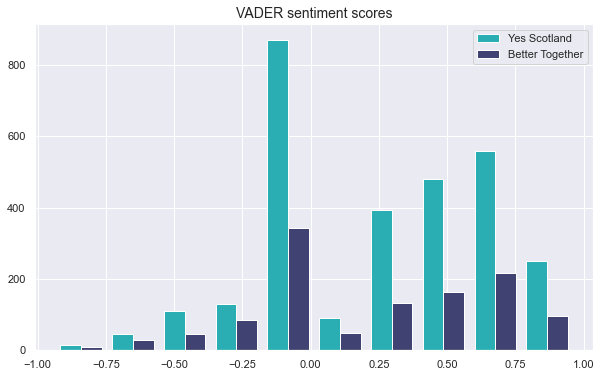

In [22]:
#Same plot using the VADER lexicon

plt.figure(figsize = (10,6))

x_multi = [tweets.loc[tweets.campaign == 'Yes Scotland']['vader_compound'].values,tweets.loc[tweets.campaign == 'Better Together']['vader_compound'].values]

plt.hist(x_multi, histtype='bar', color = colors, label = labels, align = 'mid')
plt.title('VADER sentiment scores', fontsize = 14)
plt.legend()

plt.show()

##### DEVELOPMENT OF SENTIMENT OVER TIME

Plot the development of sentiment over time for each campaign similar to figure 3, p. 503. You will need to group the sentiment scores by campaign and find the mean sentiment score per day per campaign. Plot this as a scatterplot with days on the x-axis and sentiment score on the y-axis.

This will give you a noisy plot. To fully recreate the figure from the paper, use lowess regression to show a clear picture of the development in sentiment. You can read about lowess regression here: https://towardsdatascience.com/lowess-regression-in-python-how-to-discover-clear-patterns-in-your-data-f26e523d7a35

Hint: `sns.lmplot` has an integrated lowess regression, but unfortunately it is not made to work with dates. You will either need to find a work-around or implement and plot the lowess regression separately using e.g. `statsmodels.nonparametric.smoothers_lowess.lowess`.

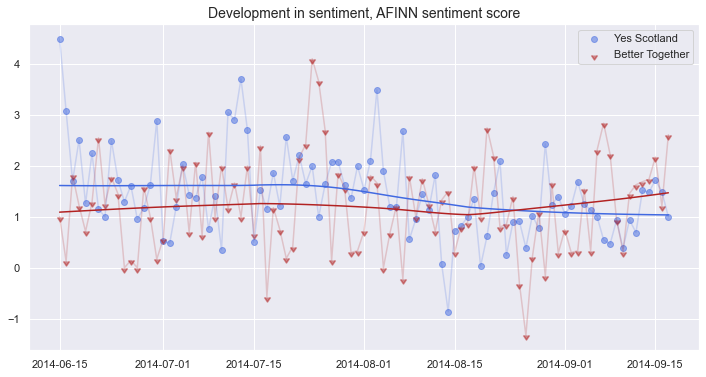

In [25]:
#Replicating figure 3, p. 503 using the AFINN dictionary 

plt.figure(figsize = (12,6))


#Defining x and y values for Yes Scotland
Yx = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean().index #Dates
Yy = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean()['afinn_sentimentscore'].values #Sentiment scores

Ycolor = 'royalblue'

#Scatterplot of Yes Scotland campaign tweets: the average sentiment score per day
plt.scatter(x = Yx, 
            y = Yy, 
            alpha = 0.5, 
            label = 'Yes Scotland',
            marker = 'o',
            color = Ycolor)

#Connecting the scatterplot dots
plt.plot(Yx, Yy, color = Ycolor, alpha = 0.2)



#Defining x and y values for Better Together 
Nx = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean().index
Ny = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean()['afinn_sentimentscore'].values

Ncolor = 'firebrick'

#Scatterplot of Better Together campaign tweets: the average sentiment score per day
plt.scatter(x = Nx, 
            y = Ny, 
            alpha = 0.5, 
            label = 'Better Together',
            marker = 11, 
            color = Ncolor)

#Connecting the scatterplot dots
plt.plot(Nx, Ny, color = Ncolor, alpha = 0.2)



#Calculating lowess (Locally Weighted Scatterplot Smoothing) regression using the statsmodel implementation 
lowess = lowess

#Calculating and plotting lowess regression for Yes Scotland
yes_lowess = lowess(Yy, Yx)[:,1]  #[:,1] to get only y-values
plt.plot(Yx, yes_lowess, color = Ycolor)

#Calculating and plotting lowess regression for Better Together
no_lowess = lowess(Ny, Nx)[:,1]
plt.plot(Nx, no_lowess, color = Ncolor)

#Plotting title and legend
plt.title("Development in sentiment, AFINN sentiment score", fontsize = 14)
plt.legend()

plt.show()

In [26]:
#Next, I will plot all three sentiment lexicons. First, I define the above code as a function.

def plot_fig3(ax, x, Yy, Ny): 

    Ycolor = 'royalblue'

    #Scatterplot of Yes Scotland campaign tweets: the average sentiment score per day
    ax.scatter(x = Yx, 
                y = Yy, 
                alpha = 0.5, 
                label = 'Yes Scotland',
                marker = 'o',
                color = Ycolor)

    #Connecting the scatterplot dots
    ax.plot(Yx, Yy, color = Ycolor, alpha = 0.2)


    Ncolor = 'firebrick'

    #Scatterplot of Better Together campaign tweets: the average sentiment score per day
    ax.scatter(x = Nx, 
                y = Ny, 
                alpha = 0.5, 
                label = 'Better Together',
                marker = 11, 
                color = Ncolor)

    #Connecting the scatterplot dots
    ax.plot(Nx, Ny, color = Ncolor, alpha = 0.2)


    #Calculating lowess regression using the statsmodel implementation 
    #lowess = lowess

    #Calculating and plotting lowess regression for Yes Scotland
    yes_lowess = lowess(Yy, Yx, frac = 2/3)[:,1]  #[:,1] to get only y-values
    ax.plot(Yx, yes_lowess, color = Ycolor)

    #Calculating and plotting lowess regression for Better Together
    no_lowess = lowess(Ny, Nx)[:,1]
    ax.plot(Nx, no_lowess, color = Ncolor)

    #Plotting legend
    ax.legend()
    

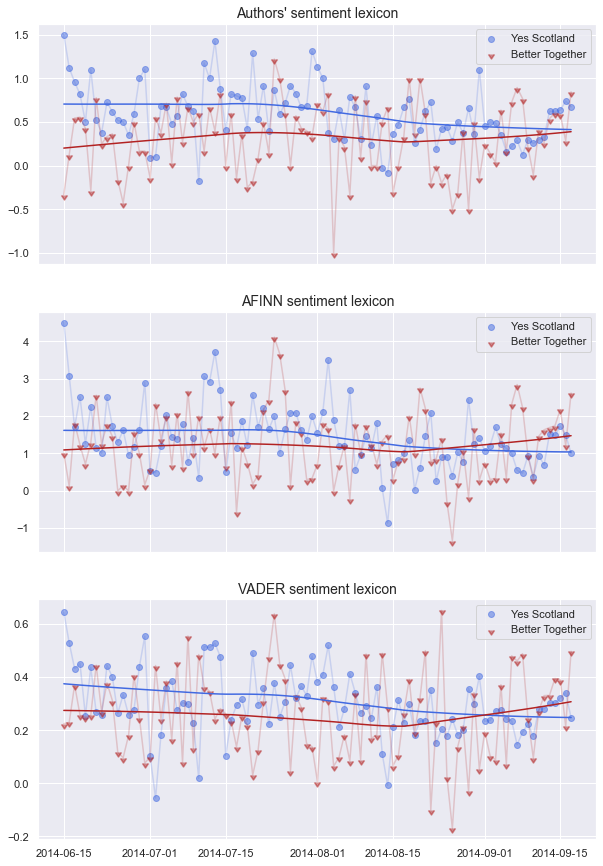

In [27]:
#Creating subplots sharing the x-axis
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex = True, figsize = (10,15))

#Plotting the authors' sentiment scores over time
x = agg.loc[agg.yesScotland == 1]['date'].values
Yy = agg.loc[agg.yesScotland == 1]['scoreDayAvg'].values
Ny = agg.loc[agg.yesScotland == 0]['scoreDayAvg'].values
plot_fig3(ax1, x, Yy, Ny)
ax1.set_title("Authors' sentiment lexicon", fontsize = 14)

#Plotting the AFINN sentiment scores over time
Yy = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean()['afinn_sentimentscore'].values
Ny = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean()['afinn_sentimentscore'].values
plot_fig3(ax2, x, Yy, Ny)
ax2.set_title("AFINN sentiment lexicon", fontsize = 14)

#Plotting the VADER sentiment scores over time
Yy = tweets.loc[tweets.campaign == 'Yes Scotland'].groupby('date').mean()['vader_compound'].values
Ny = tweets.loc[tweets.campaign == 'Better Together'].groupby('date').mean()['vader_compound'].values
plot_fig3(ax3, x, Yy, Ny)
ax3.set_title("VADER sentiment lexicon", fontsize = 14)

plt.show()
